0. Import the libraries

In [95]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [96]:
!pip install matplotlib


In [97]:
!pip install timm


In [98]:
!pip install transformers


In [99]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer


import timm
from PIL import Image

import math
import matplotlib.pyplot as plt
import os

1. Image Encoder

1a. Define image encoder model

In [100]:
class ImageEmbedding(nn.Module):
    def __init__(self, model_name, embed_dim, transform_methods ,drop_out = 0.5, device = "cpu"):
        super(ImageEmbedding, self).__init__()

        # Normalize image
        self.normalize = transform_methods

        # Load the specified pre-trained model
        if model_name.startswith('resnet'):
            if model_name == 'resnet50':
                self.model = models.resnet50(pretrained=True)
            elif model_name == 'resnet101':
                self.model = models.resnet101(pretrained=True)
            elif model_name == 'resnet152':
                self.model = models.resnet152(pretrained=True)
            else:
                raise ValueError(f"Unsupported ResNet model: {model_name}")
                
            num_features = self.model.fc.in_features
            self.model.fc = nn.Linear(num_features, embed_dim)
        
        elif model_name.startswith('densenet'):
            if model_name == 'densenet121':
                self.model = models.densenet121(pretrained=True)
            else:
                raise ValueError(f"Unsupported DenseNet model: {model_name}")
                
            num_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(num_features, embed_dim)
        
        elif model_name.startswith('vit'):
            self.model = timm.create_model(model_name, pretrained=True)

            num_features = self.model.head.in_features
            self.model.head = nn.Linear(num_features, embed_dim)
        
        else:
            raise ValueError(f"Unsupported model: {model_name}")
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=drop_out)
        self.device = device
    def forward(self, image):
        image = self.normalize(image)
        image = image.to(self.device)
        image = torch.unsqueeze(image, dim=0)
        features = self.model(image)
        features = self.relu(features)
        features = self.dropout(features)
        return features

1b. Test

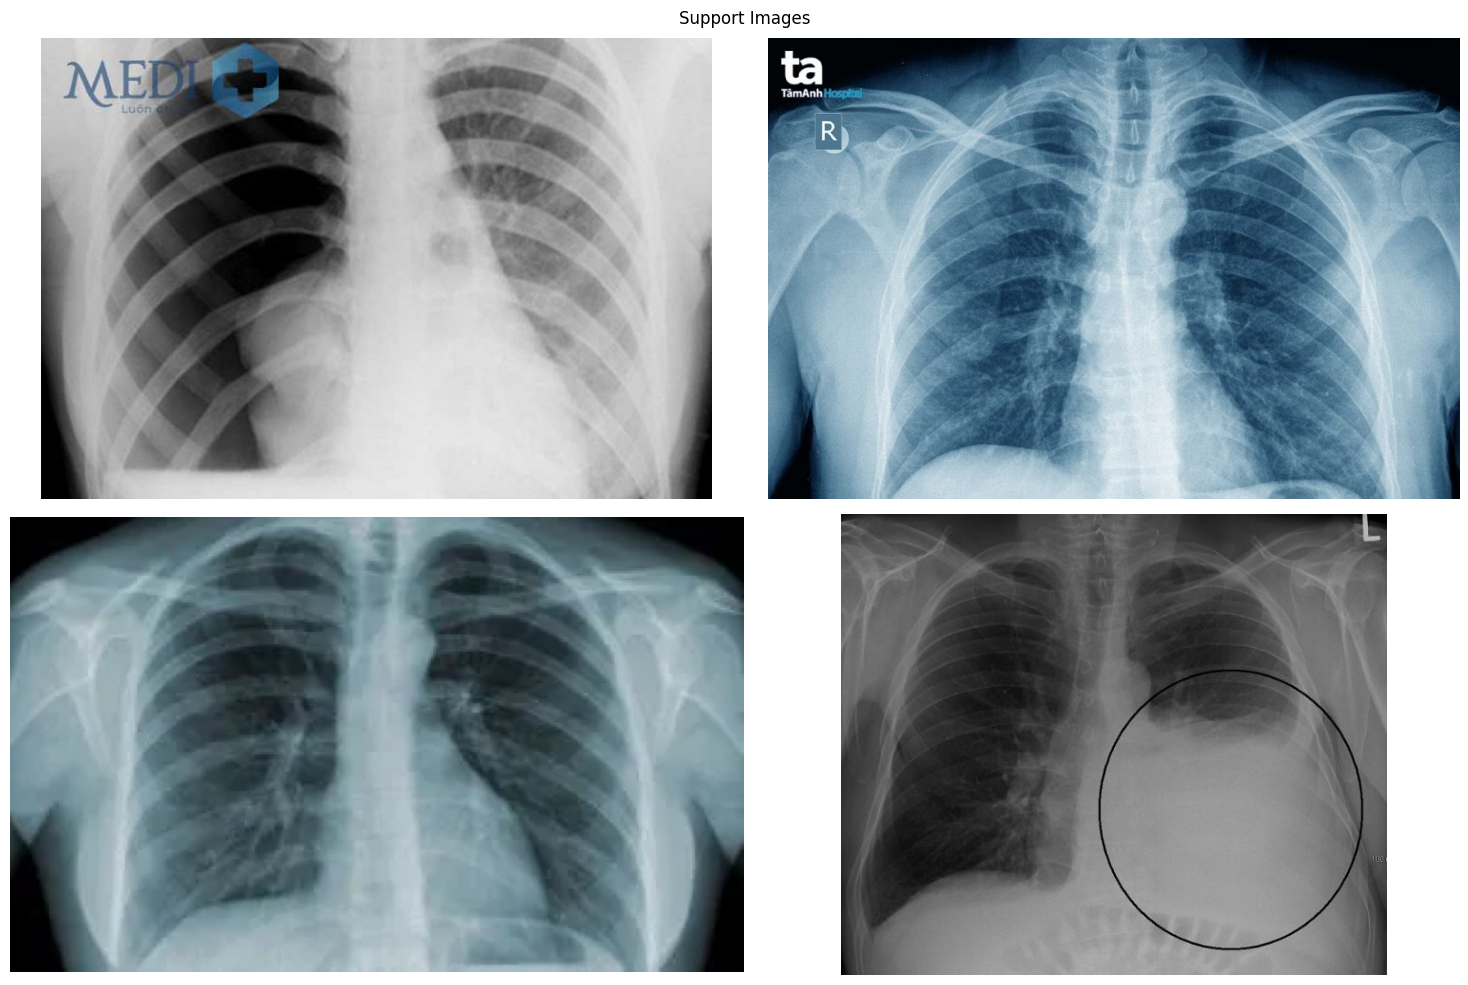

In [101]:
## Visualize Support Images
support_folder_path = "dataset/support"
suport_image_paths = [os.path.join(support_folder_path, path) for path in os.listdir(support_folder_path)]
images_rgba = [Image.open(image_path).convert("RGBA") for image_path in suport_image_paths]


support_images = []
for image in images_rgba:
    if image.mode == 'RGBA':
        image_rgb = image.convert('RGB')
    else:
        image_rgb = image

    support_images.append(image_rgb)
rows = 2
cols = 2
figsize=(15, 10)
num_images = len(support_images)
cols = (num_images + rows - 1) // rows

fig, axes = plt.subplots(rows, cols, figsize=figsize)

for i, ax in enumerate(axes.flat):
    if i < num_images:
        ax.imshow(support_images[i])
        ax.axis('off')
    else:
        ax.axis('off')

plt.suptitle("Support Images")
plt.tight_layout()
plt.show()

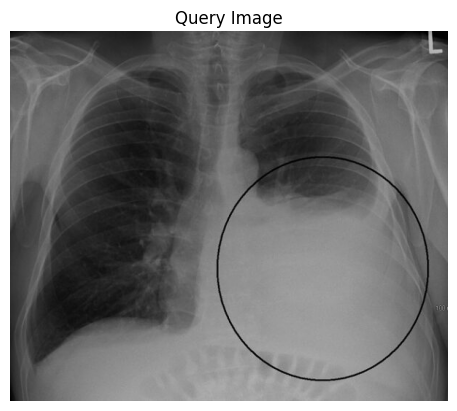

In [102]:
### Visualize query image
query_image_path = "dataset/query/vai-tro-cua-chup-x-quang-trong-chan-doan-hinh-anh-lao-phoi-3-e1686630613245.png"
query_image = Image.open(query_image_path).convert("RGBA").convert("RGB")

# Plot the image with title
plt.imshow(image)
plt.title("Query Image")
plt.axis('off')  # Hide axis
plt.show()

In [103]:
transform_method = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
embed_size = 512  # Set the desired output size of the encoder
model_name = 'vit_base_patch16_224'  # Choose the desired ViT model

embedding = ImageEmbedding(model_name=model_name, embed_dim=embed_size, transform_methods=transform_method, drop_out=0.5)


In [104]:
# Encode support images
encoded_features_list = []
for image in support_images:
    encoded_features = embedding(image)
    encoded_features_list.append(encoded_features)

# Convert list of encoded features to a single tensor
encoded_support_tensor = torch.concat(encoded_features_list)
print(encoded_support_tensor)

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.4336, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<CatBackward0>)


In [105]:
# Encode query images
encoded_query_tensor = embedding(query_image)
print(encoded_query_tensor.size())

torch.Size([1, 512])


In [106]:
#Cosin similarity
cos_sim = F.cosine_similarity(encoded_query_tensor, encoded_support_tensor, dim=1)
softmax_scores = F.softmax(cos_sim, dim=-1)

print(softmax_scores)


tensor([0.2436, 0.2650, 0.2387, 0.2527], grad_fn=<SoftmaxBackward0>)


2. Ranking model

2a. Definition

In [107]:
class PositionalEncoding(nn.Module):
    def __init__(self):
        super(PositionalEncoding, self).__init__()

    def forward(self, x):
        max_len, d_model = x.size(0), x.size(1)
        encoding = self.positional_encoding(max_len, d_model, device=x.device, dtype=x.dtype)
        x = x + encoding
        return x

    def positional_encoding(self, max_len, d_model, device, dtype):
        position = torch.arange(0, max_len, dtype=dtype, device=device).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=dtype, device=device) * (-math.log(10000.0) / d_model))

        # Tính toán positional encoding cho mỗi hàng của ma trận input
        encoding = torch.zeros(1, max_len, d_model, dtype=dtype, device=device)
        encoding[:, :, 0::2] = torch.sin(position / div_term)
        encoding[:, :, 1::2] = torch.cos(position / div_term)

        return encoding

In [117]:
class FeatureEncoding(nn.Module):
    def __init__(self, d_model = 512, nhead = 2, dim_feedforward = 1024, n_layer = 2, drop_out =0.5, output_dim = 512, device = "cpu"):
        super(FeatureEncoding, self).__init__()
        encoder_layers = TransformerEncoderLayer(d_model, nhead, dim_feedforward, drop_out).to(device)
        self.transformer_model = TransformerEncoder(encoder_layers, n_layer).to(device)
        self.fc = nn.Linear(d_model, output_dim)
        self.device = device
    def forward(self, feature):
        feature = feature.to(self.device)
        feature = self.transformer_model(feature)
        feature = self.fc(feature)
        return feature

In [136]:
class RankingModel(nn.Module):
    def __init__(self, model_name, embed_dim, transform_methods, drop_out,d_model = 512, nhead = 2, dim_feedforward = 1024, n_layer = 2, output_dim = 1024, device = "cpu"):
        super(RankingModel, self).__init__()
        self.embedding = ImageEmbedding(model_name=model_name, embed_dim=embed_dim, transform_methods=transform_methods, drop_out=drop_out, device=device).to(device)
        self.position_model = PositionalEncoding().to(device)
        self.encoding = FeatureEncoding(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, n_layer=n_layer, drop_out=drop_out, output_dim=output_dim, device=device).to(device)

        self.device = device

    def forward(self, support_images, query_image):
        #Encoder support images
        encoded_features_list = []
        for image in support_images:
            encoded_features = self.embedding(image)
            encoded_features_list.append(encoded_features)

        encoded_support_tensor = torch.concat(encoded_features_list)
        encoded_support_tensor = self.position_model(encoded_support_tensor)
        encoded_support_tensor = self.encoding(encoded_support_tensor)
        print("Support:" + str(encoded_support_tensor.size()))
        #Encoder query image
        encoded_query_tensor = embedding(query_image).unsqueeze(1)
        print("Query:" + str(encoded_query_tensor.size()))
        # CLIP Ideal
        cos_sim = F.cosine_similarity(encoded_query_tensor, encoded_support_tensor, dim=2)
        softmax_scores = F.softmax(cos_sim, dim=-1)
        return softmax_scores

2b. Test

In [137]:
# Config
transform_method = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(50),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
embed_size = 512  # Set the desired output size of the encoder
model_name = 'vit_base_patch16_224'  # Choose the desired ViT model
drop_out = 0.5

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)
HealthyRankingModel = RankingModel(model_name=model_name, embed_dim=embed_size, transform_methods=transform_method, drop_out=drop_out, d_model = 512, nhead = 2, dim_feedforward = 1024, n_layer = 2, output_dim = 512, device="cpu")

scores = HealthyRankingModel(support_images, query_image)

print(scores)

Support:torch.Size([1, 4, 512])
Query:torch.Size([1, 1, 512])
tensor([[0.2471, 0.2444, 0.2582, 0.2503]], grad_fn=<SoftmaxBackward0>)
